In [4416]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [4417]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [4418]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168139 entries, 0 to 2168138
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 33.1 MB


# reduce to 1 million events

In [4419]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [4420]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,45814,0.08,45.814
1,45953,0.08,45.953
2,45883,0.08,45.883
3,45748,0.08,45.748
4,45956,0.08,45.956
...,...,...,...
999995,23727,0.15,23.727
999996,23884,0.15,23.884
999997,23538,0.15,23.538
999998,22967,0.16,22.967


In [4421]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [4422]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [4423]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

25987456396000

### Calcul de la date de base = now - cumul_interval

In [4424]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 2, 16, 16, 34, 666372)

In [4425]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [4426]:
conso_data.iloc[0]


Interval     45814.0000
kWh              0.0800
sec             45.8140
Wh              78.5786
cumul(ms)    45814.0000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [4427]:
base

datetime.datetime(2024, 7, 2, 16, 16, 34, 666372)

## créer les dates

In [4428]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-02 16:17:20.480372
1        2024-07-02 16:18:06.433372
2        2024-07-02 16:18:52.316372
3        2024-07-02 16:19:38.064372
4        2024-07-02 16:20:24.020372
                    ...            
999995   2025-04-29 10:59:16.748372
999996   2025-04-29 10:59:40.632372
999997   2025-04-29 11:00:04.170372
999998   2025-04-29 11:00:27.137372
999999   2025-04-29 11:00:51.062372
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [4429]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,45814,0.08,45.814,78.578600,45814,2024-07-02 16:17:20.480372,02/07/24
1,45953,0.08,45.953,78.340914,91767,2024-07-02 16:18:06.433372,02/07/24
2,45883,0.08,45.883,78.460432,137650,2024-07-02 16:18:52.316372,02/07/24
3,45748,0.08,45.748,78.691965,183398,2024-07-02 16:19:38.064372,02/07/24
4,45956,0.08,45.956,78.335799,229354,2024-07-02 16:20:24.020372,02/07/24
...,...,...,...,...,...,...,...
999995,23727,0.15,23.727,151.725882,25987362082,2025-04-29 10:59:16.748372,29/04/25
999996,23884,0.15,23.884,150.728521,25987385966,2025-04-29 10:59:40.632372,29/04/25
999997,23538,0.15,23.538,152.944175,25987409504,2025-04-29 11:00:04.170372,29/04/25
999998,22967,0.16,22.967,156.746636,25987432471,2025-04-29 11:00:27.137372,29/04/25


### save conso_data with dates

In [4430]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [4431]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('29/04/25', 29, 4, 2025, '11:01:07')

In [4432]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [4433]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1831 entries, 998169 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1831 non-null   int64         
 1   kWh        1831 non-null   float64       
 2   sec        1831 non-null   float64       
 3   Wh         1831 non-null   float64       
 4   cumul(ms)  1831 non-null   int64         
 5   dates      1831 non-null   datetime64[ns]
 6   days       1831 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 114.4+ KB


In [4434]:
end = time.time()
print(end - start)

20.72434949874878


### grouped by days

In [4435]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [4436]:
data = list(df_grp['kWh'])
print(data)

[0.666, 2.087, 2.076, 2.079, 2.082, 3.554, 3.196, 3.389, 3.867, 3.516, 3.872, 3.505, 3.549, 3.756, 3.495, 3.396, 3.273, 3.473, 3.287, 3.724, 3.663, 3.589, 3.598, 3.429, 3.256, 3.178, 2.85, 3.054, 3.675, 3.748, 3.841, 3.012, 3.332, 3.352, 3.495, 3.665, 3.575, 3.577, 3.8, 3.858, 3.671, 4.384, 4.287, 3.895, 3.899, 4.033, 3.806, 3.843, 3.703, 3.289, 3.925, 3.941, 4.445, 3.776, 4.119, 3.792, 3.966, 3.782, 3.959, 3.708, 3.602, 3.5, 3.678, 3.517, 4.129, 3.711, 3.442, 3.547, 3.251, 2.431, 1.795, 1.793, 1.793, 1.796, 2.487, 1.851, 1.788, 1.791, 1.79, 1.821, 1.822, 1.815, 1.817, 1.818, 1.818, 1.815, 1.813, 1.786, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.789, 1.785, 1.796, 1.803, 1.795, 1.803, 1.796, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.805, 3.994, 3.646, 3.923, 3.087, 3.617, 3.988, 3.441, 3.394, 3.95, 3.342, 4.167, 3.086, 4.032, 3.143, 3.359, 3.499, 3.988, 3.3, 3.363, 3.824, 3.23, 3.547, 3.357, 3.855, 3.4, 3.859, 3.223, 4.466, 3.676, 3.813, 3.482, 4.082, 

In [4437]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [4438]:
end = time.time()
print(end - start)

24.123284578323364


### plot function by day
#### show('dd/mm/yy')

In [4439]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


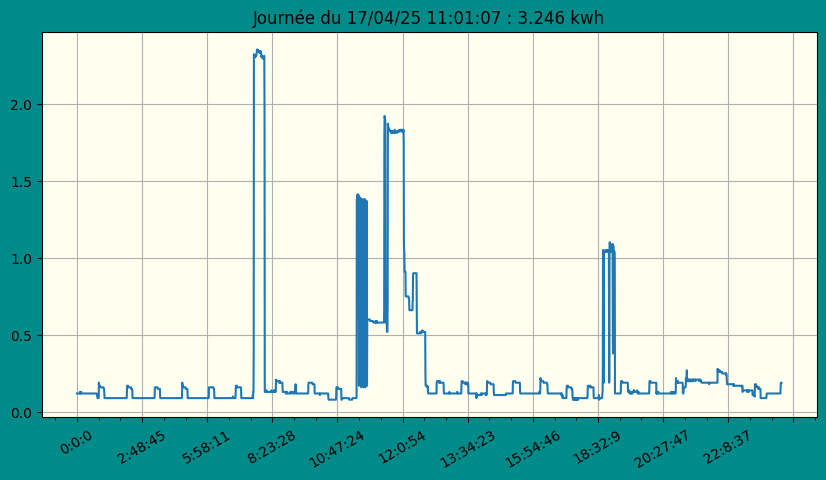

In [4440]:
show('17/04/25')

In [4441]:
end = time.time()
print(end - start)

27.914971828460693


### 1 kWh window in data of one day
#### df = conso_day

In [4442]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998169,36749,0.10,36.749,97.961849,25947814856,2025-04-29 00:00:09.522372,29/04/25
998170,35506,0.10,35.506,101.391314,25947850362,2025-04-29 00:00:45.028372,29/04/25
998171,34595,0.10,34.595,104.061281,25947884957,2025-04-29 00:01:19.623372,29/04/25
998172,35489,0.10,35.489,101.439883,25947920446,2025-04-29 00:01:55.112372,29/04/25
998173,36359,0.10,36.359,99.012624,25947956805,2025-04-29 00:02:31.471372,29/04/25
...,...,...,...,...,...,...,...
999995,23727,0.15,23.727,151.725882,25987362082,2025-04-29 10:59:16.748372,29/04/25
999996,23884,0.15,23.884,150.728521,25987385966,2025-04-29 10:59:40.632372,29/04/25
999997,23538,0.15,23.538,152.944175,25987409504,2025-04-29 11:00:04.170372,29/04/25
999998,22967,0.16,22.967,156.746636,25987432471,2025-04-29 11:00:27.137372,29/04/25


In [4443]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [4444]:
df = conso_day
len(df)

1831

In [4445]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-04-29 00:00:09.522372	2025-04-29 08:48:39.341372	8h 48m 29s 	1000
2025-04-29 08:48:39.341372	2025-04-29 11:00:51.062372	2h 12m 11s 	831


In [4446]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.296094
dtype: float64

In [4447]:
end = time.time()
print(end - start)

28.307864904403687


## mean for data grouped by days

In [4448]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.311258
dtype: float64

In [4449]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.831)

# conso by date


In [4450]:
# select day
day = today

#day = '16/08/24'
day

'29/04/25'

In [4451]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998169,36749,0.10,36.749,97.961849,25947814856,2025-04-29 00:00:09.522372,29/04/25
998170,35506,0.10,35.506,101.391314,25947850362,2025-04-29 00:00:45.028372,29/04/25
998171,34595,0.10,34.595,104.061281,25947884957,2025-04-29 00:01:19.623372,29/04/25
998172,35489,0.10,35.489,101.439883,25947920446,2025-04-29 00:01:55.112372,29/04/25
998173,36359,0.10,36.359,99.012624,25947956805,2025-04-29 00:02:31.471372,29/04/25
...,...,...,...,...,...,...,...
999995,23727,0.15,23.727,151.725882,25987362082,2025-04-29 10:59:16.748372,29/04/25
999996,23884,0.15,23.884,150.728521,25987385966,2025-04-29 10:59:40.632372,29/04/25
999997,23538,0.15,23.538,152.944175,25987409504,2025-04-29 11:00:04.170372,29/04/25
999998,22967,0.16,22.967,156.746636,25987432471,2025-04-29 11:00:27.137372,29/04/25


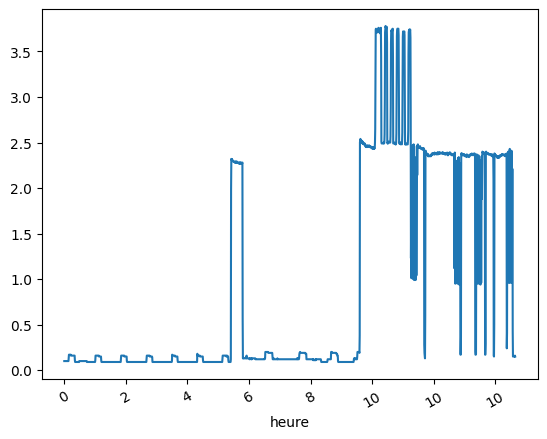

In [4452]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [4453]:
end = time.time()
print(end - start)

29.60664391517639


### grouped by 'heure'

In [4454]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1831 entries, 998169 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1831 non-null   int64         
 1   kWh        1831 non-null   float64       
 2   sec        1831 non-null   float64       
 3   Wh         1831 non-null   float64       
 4   cumul(ms)  1831 non-null   int64         
 5   dates      1831 non-null   datetime64[ns]
 6   days       1831 non-null   object        
 7   heure      1831 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 128.7+ KB


In [4455]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,36749,0.10,36.749,97.961849,25947814856,2025-04-29 00:00:09.522372,29/04/25
0,35506,0.10,35.506,101.391314,25947850362,2025-04-29 00:00:45.028372,29/04/25
0,34595,0.10,34.595,104.061281,25947884957,2025-04-29 00:01:19.623372,29/04/25
0,35489,0.10,35.489,101.439883,25947920446,2025-04-29 00:01:55.112372,29/04/25
0,36359,0.10,36.359,99.012624,25947956805,2025-04-29 00:02:31.471372,29/04/25
...,...,...,...,...,...,...,...
10,23727,0.15,23.727,151.725882,25987362082,2025-04-29 10:59:16.748372,29/04/25
10,23884,0.15,23.884,150.728521,25987385966,2025-04-29 10:59:40.632372,29/04/25
11,23538,0.15,23.538,152.944175,25987409504,2025-04-29 11:00:04.170372,29/04/25


In [4456]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [4457]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     107
1     100
2     100
3      99
4      99
5      98
6     156
7     133
8     129
9     114
10    693
11      3
Name: kWh, dtype: int64

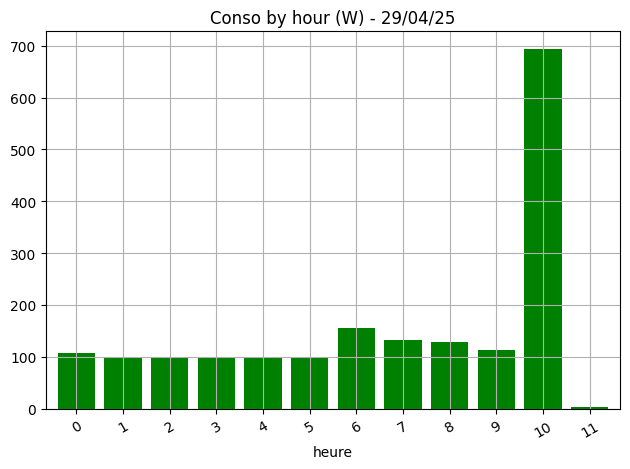

In [4458]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [4459]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 02/07/24 to 29/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     302 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [4460]:
# give the periods of 1 kwh in a day
period()

2025-04-29 00:00:09.522372	2025-04-29 08:48:39.341372	8h 48m 29s 	1000


In [4461]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [4462]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [4463]:
df_grp.mean()


kWh    3.311258
dtype: float64

In [4464]:
df_grp.head()


,kWh
days,
02/07/24,0.666
03/07/24,2.087
04/07/24,2.076
05/07/24,2.079
06/07/24,2.082


In [4465]:
df_grp.tail()


,kWh
days,
25/04/25,3.010
26/04/25,2.768
27/04/25,3.100
28/04/25,3.623
29/04/25,1.831


In [4466]:
end = time.time()
print(end - start)

31.462092638015747


# plot les 100 derniers jours


In [4467]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.52567
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

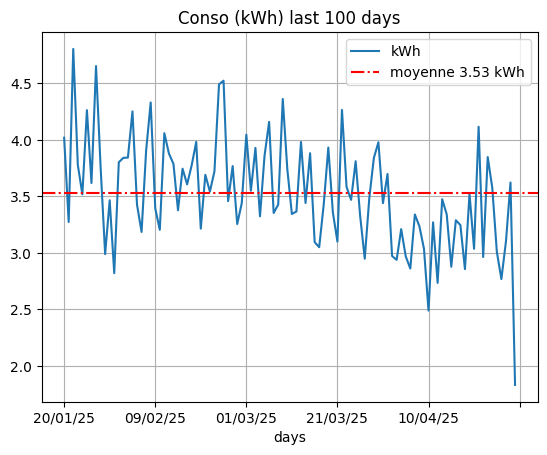

In [4468]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [4469]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.831
max,4.805


In [4470]:
end = time.time()
print(end - start)

32.29700493812561


In [4471]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('30/03/25', '24/04/25')

In [4472]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.227233
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

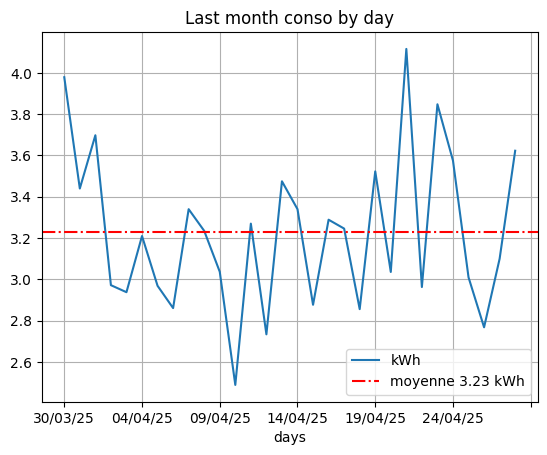

In [4473]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [4474]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 21/04/25 4.116
Min : 10/04/25 2.489


# Temps de conso par tranche de 1 kWh

In [4475]:

tranches = len(df)//1000
tranches+1


2

In [4476]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-29 00:00:09.522372	2025-04-29 08:48:39.341372	8h 48m 29s 	1000
2025-04-29 08:48:39.341372	2025-04-29 11:00:51.062372	2h 12m 11s 	831


('11:01:07', 1.831, 1831)

In [4477]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1831 entries, 998169 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1831 non-null   int64         
 1   kWh        1831 non-null   float64       
 2   sec        1831 non-null   float64       
 3   Wh         1831 non-null   float64       
 4   cumul(ms)  1831 non-null   int64         
 5   dates      1831 non-null   datetime64[ns]
 6   days       1831 non-null   object        
 7   heure      1831 non-null   object        
 8   hours      1831 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 143.0+ KB


In [4478]:
conso_hours['heure'], conso_hours['hours']

(998169     0
 998170     0
 998171     0
 998172     0
 998173     0
           ..
 999995    10
 999996    10
 999997    11
 999998    11
 999999    11
 Name: heure, Length: 1831, dtype: object,
 998169    00
 998170    00
 998171    00
 998172    00
 998173    00
           ..
 999995    10
 999996    10
 999997    11
 999998    11
 999999    11
 Name: hours, Length: 1831, dtype: object)

In [4479]:
end = time.time()
print(end - start)

33.287047386169434


# select number of days to display


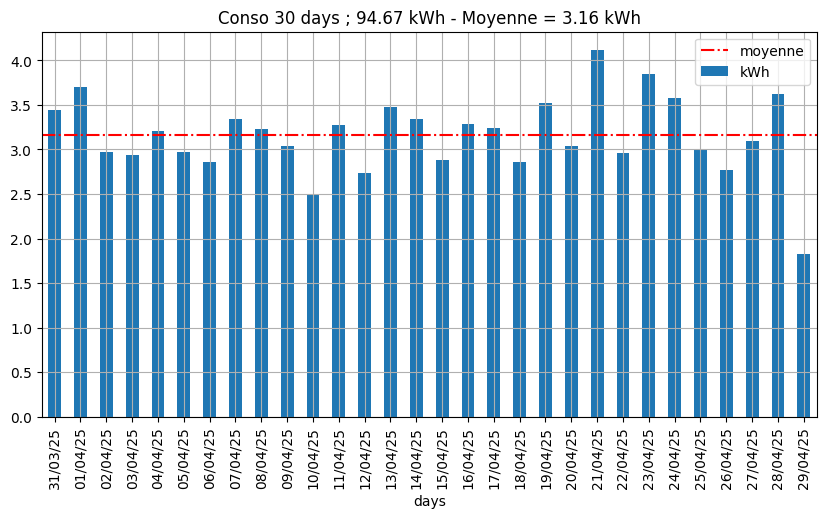

In [4480]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


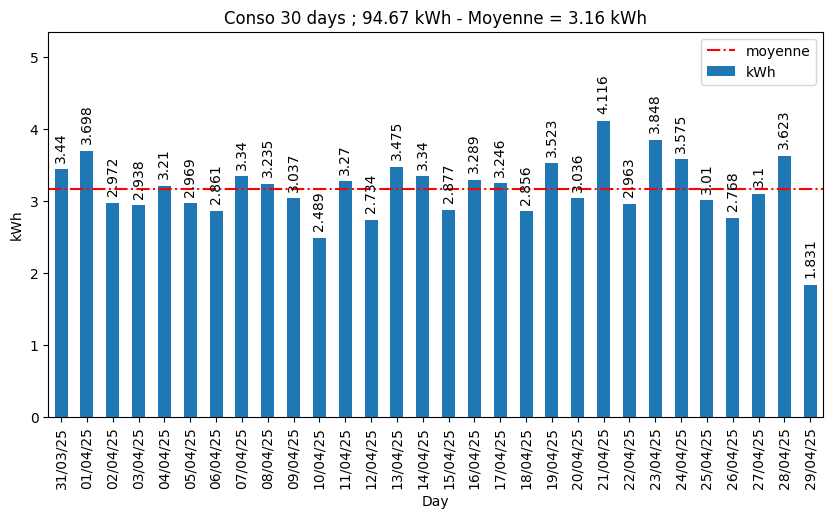

In [4481]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [4482]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
31/03/25    3.440
01/04/25    3.698
02/04/25    2.972
03/04/25    2.938
04/04/25    3.210
05/04/25    2.969
06/04/25    2.861
07/04/25    3.340
08/04/25    3.235
09/04/25    3.037
10/04/25    2.489
11/04/25    3.270
12/04/25    2.734
13/04/25    3.475
14/04/25    3.340
15/04/25    2.877
16/04/25    3.289
17/04/25    3.246
18/04/25    2.856
19/04/25    3.523
20/04/25    3.036
21/04/25    4.116
22/04/25    2.963
23/04/25    3.848
24/04/25    3.575
25/04/25    3.010
26/04/25    2.768
27/04/25    3.100
28/04/25    3.623
29/04/25    1.831
Name: kWh, dtype: float64

In [4483]:
x_labels=df_grp.tail(span).index
x_labels

Index(['31/03/25', '01/04/25', '02/04/25', '03/04/25', '04/04/25', '05/04/25',
       '06/04/25', '07/04/25', '08/04/25', '09/04/25', '10/04/25', '11/04/25',
       '12/04/25', '13/04/25', '14/04/25', '15/04/25', '16/04/25', '17/04/25',
       '18/04/25', '19/04/25', '20/04/25', '21/04/25', '22/04/25', '23/04/25',
       '24/04/25', '25/04/25', '26/04/25', '27/04/25', '28/04/25', '29/04/25'],
      dtype='object', name='days')

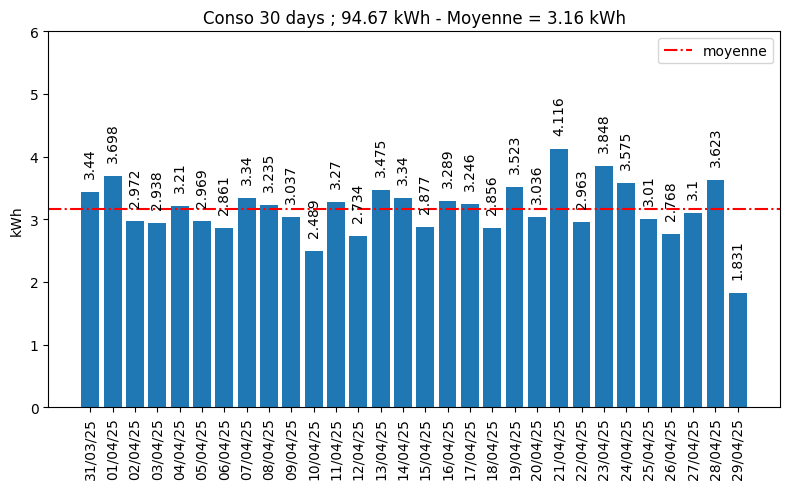

In [4484]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [4485]:
end = time.time()
print(end - start)

39.69061779975891


In [4486]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

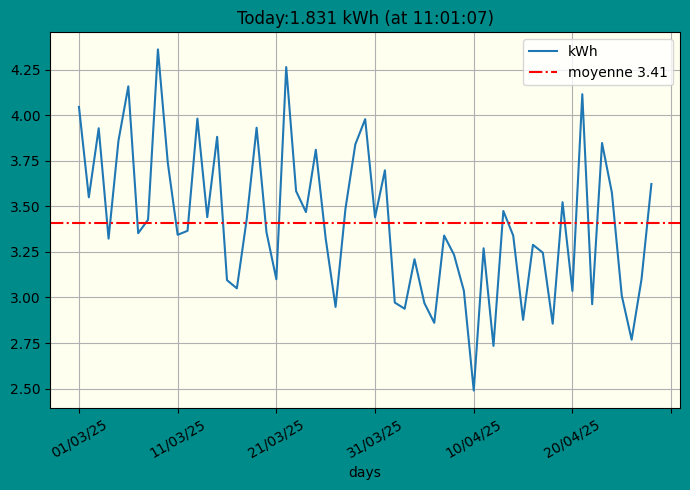

In [4487]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

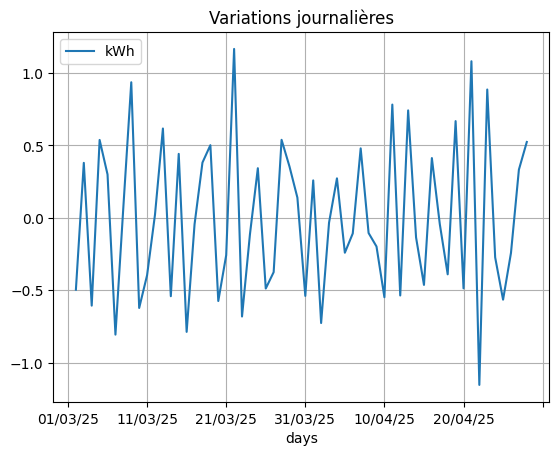

In [4488]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [4489]:
end = time.time()
print(end - start)

41.34927010536194


# Data from 21/08/23

In [4490]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,45814,0.08,45.814,78.578600,45814,2024-07-02 16:17:20.480372,02/07/24,16,2024-07,02
1,45953,0.08,45.953,78.340914,91767,2024-07-02 16:18:06.433372,02/07/24,16,2024-07,02
2,45883,0.08,45.883,78.460432,137650,2024-07-02 16:18:52.316372,02/07/24,16,2024-07,02
3,45748,0.08,45.748,78.691965,183398,2024-07-02 16:19:38.064372,02/07/24,16,2024-07,02
4,45956,0.08,45.956,78.335799,229354,2024-07-02 16:20:24.020372,02/07/24,16,2024-07,02
...,...,...,...,...,...,...,...,...,...,...
999995,23727,0.15,23.727,151.725882,25987362082,2025-04-29 10:59:16.748372,29/04/25,10,2025-04,29
999996,23884,0.15,23.884,150.728521,25987385966,2025-04-29 10:59:40.632372,29/04/25,10,2025-04,29
999997,23538,0.15,23.538,152.944175,25987409504,2025-04-29 11:00:04.170372,29/04/25,11,2025-04,29
999998,22967,0.16,22.967,156.746636,25987432471,2025-04-29 11:00:27.137372,29/04/25,11,2025-04,29


In [4491]:
end = time.time()
print(end - start)

79.71624040603638


In [4492]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

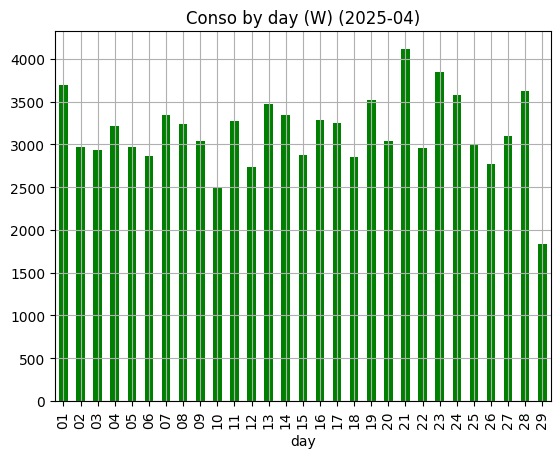

In [4493]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [4494]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3145.8275862068967)

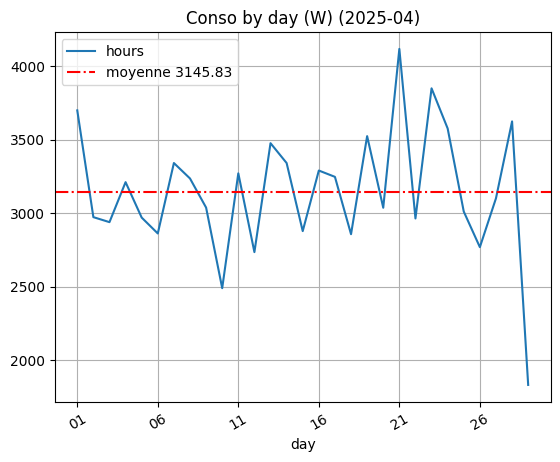

In [4495]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [4496]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

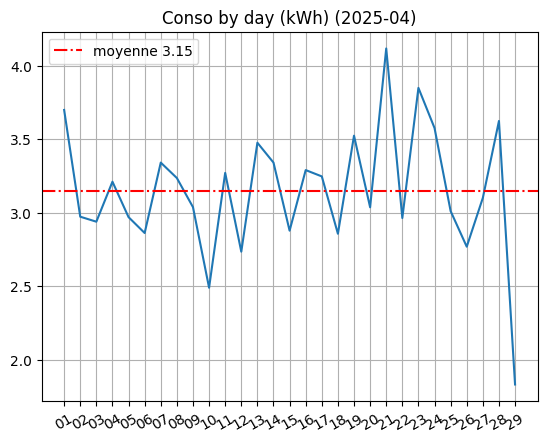

In [4497]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [4498]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [4499]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [4500]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,95882,95882,95882
2024-08,117332,117332,117332
2024-09,69773,69773,69773
2024-10,73514,73514,73514
2024-11,108515,108515,108515
2024-12,113764,113764,113764
2025-01,113618,113618,113618
2025-02,104498,104498,104498
2025-03,111875,111875,111875


In [4501]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [4502]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [4503]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
02/07/24,666
03/07/24,2087
04/07/24,2076
05/07/24,2079
06/07/24,2082
...,...
25/04/25,3010
26/04/25,2768
27/04/25,3100


In [4504]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,45814,0.08,45.814,78.578600,45814,2024-07-02 16:17:20.480372,02/07/24,16,2024-07,02
1,45953,0.08,45.953,78.340914,91767,2024-07-02 16:18:06.433372,02/07/24,16,2024-07,02
2,45883,0.08,45.883,78.460432,137650,2024-07-02 16:18:52.316372,02/07/24,16,2024-07,02
3,45748,0.08,45.748,78.691965,183398,2024-07-02 16:19:38.064372,02/07/24,16,2024-07,02
4,45956,0.08,45.956,78.335799,229354,2024-07-02 16:20:24.020372,02/07/24,16,2024-07,02
...,...,...,...,...,...,...,...,...,...,...
999995,23727,0.15,23.727,151.725882,25987362082,2025-04-29 10:59:16.748372,29/04/25,10,2025-04,29
999996,23884,0.15,23.884,150.728521,25987385966,2025-04-29 10:59:40.632372,29/04/25,10,2025-04,29
999997,23538,0.15,23.538,152.944175,25987409504,2025-04-29 11:00:04.170372,29/04/25,11,2025-04,29
999998,22967,0.16,22.967,156.746636,25987432471,2025-04-29 11:00:27.137372,29/04/25,11,2025-04,29


In [4505]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
02/07/24 16    0       02/07/24    16  0.08
               1       02/07/24    16  0.08
               2       02/07/24    16  0.08
               3       02/07/24    16  0.08
               4       02/07/24    16  0.08
...                         ...   ...   ...
29/04/25 10    999995  29/04/25    10  0.15
               999996  29/04/25    10  0.15
         11    999997  29/04/25    11  0.15
               999998  29/04/25    11  0.16
               999999  29/04/25    11  0.15

[1000000 rows x 3 columns]

In [4506]:
groupallbyday.indices.keys()

dict_keys(['02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/0

In [4507]:
groupallbydayhours.indices.keys()

dict_keys([('02/07/24', '16'), ('02/07/24', '17'), ('02/07/24', '18'), ('02/07/24', '19'), ('02/07/24', '20'), ('02/07/24', '21'), ('02/07/24', '22'), ('02/07/24', '23'), ('03/07/24', '16'), ('03/07/24', '17'), ('03/07/24', '18'), ('03/07/24', '19'), ('03/07/24', '20'), ('03/07/24', '21'), ('03/07/24', '22'), ('03/07/24', '23'), ('03/07/24', '00'), ('03/07/24', '01'), ('03/07/24', '02'), ('03/07/24', '03'), ('03/07/24', '04'), ('03/07/24', '05'), ('03/07/24', '06'), ('03/07/24', '07'), ('03/07/24', '08'), ('03/07/24', '09'), ('03/07/24', '10'), ('03/07/24', '11'), ('03/07/24', '12'), ('03/07/24', '13'), ('03/07/24', '14'), ('03/07/24', '15'), ('04/07/24', '16'), ('04/07/24', '17'), ('04/07/24', '18'), ('04/07/24', '19'), ('04/07/24', '20'), ('04/07/24', '21'), ('04/07/24', '22'), ('04/07/24', '23'), ('04/07/24', '00'), ('04/07/24', '01'), ('04/07/24', '02'), ('04/07/24', '03'), ('04/07/24', '04'), ('04/07/24', '05'), ('04/07/24', '06'), ('04/07/24', '07'), ('04/07/24', '08'), ('04/07/2

In [4508]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
02/07/24,666,666
03/07/24,2087,2087
04/07/24,2076,2076
05/07/24,2079,2079
06/07/24,2082,2082
...,...,...
25/04/25,3010,3010
26/04/25,2768,2768
27/04/25,3100,3100


In [4509]:
grp_by_day['kWh'].cumsum()

days
02/07/24        666
03/07/24       2753
04/07/24       4829
05/07/24       6908
06/07/24       8990
             ...   
25/04/25     988678
26/04/25     991446
27/04/25     994546
28/04/25     998169
29/04/25    1000000
Name: kWh, Length: 302, dtype: int64

In [4510]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
02/07/24 16      63
         17      84
         18      92
         19      83
         20      84
...             ...
29/04/25 07     133
         08     129
         09     114
         10     693
         11       3

[7220 rows x 1 columns]

In [4511]:
grp_by_dayhours['kWh'].cumsum()

days      hours
02/07/24  16            63
          17           147
          18           239
          19           322
          20           406
                    ...   
29/04/25  07        999061
          08        999190
          09        999304
          10        999997
          11       1000000
Name: kWh, Length: 7220, dtype: int64

In [4512]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
02/07/24 16      63      63    NaN
         17      84     147   21.0
         18      92     239    8.0
         19      83     322   -9.0
         20      84     406    1.0
...             ...     ...    ...
29/04/25 07     133     892  -23.0
         08     129    1021   -4.0
         09     114    1135  -15.0
         10     693    1828  579.0
         11       3    1831 -690.0

[7220 rows x 3 columns]

In [4513]:
today, grp_by_dayhours.loc[today]

('29/04/25',
        kWh  cumsum   diff
 hours                    
 00     107     107    NaN
 01     100     207   -7.0
 02     100     307    0.0
 03      99     406   -1.0
 04      99     505    0.0
 05      98     603   -1.0
 06     156     759   58.0
 07     133     892  -23.0
 08     129    1021   -4.0
 09     114    1135  -15.0
 10     693    1828  579.0
 11       3    1831 -690.0)

Text(0.5, 1.0, 'Cumul journalier')

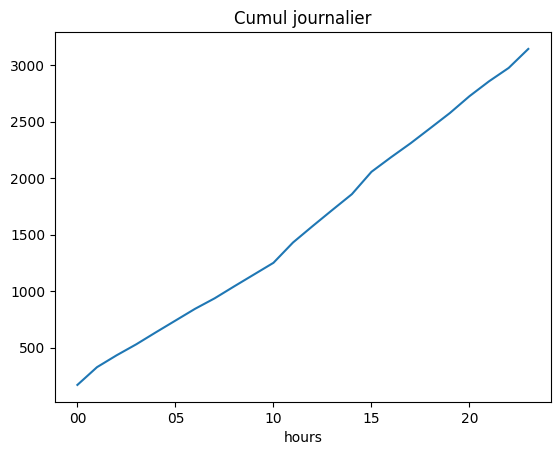

In [4514]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

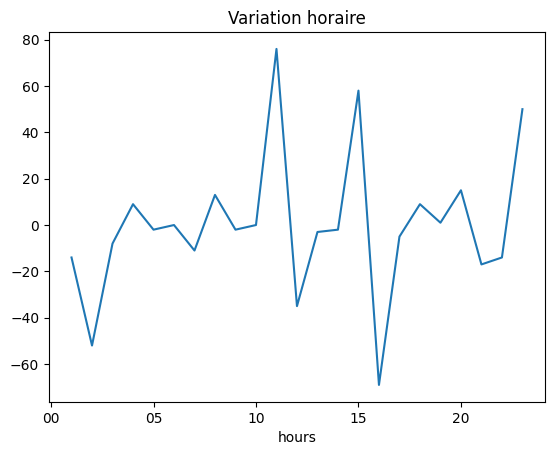

In [4515]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [4516]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

302

In [4517]:
df_grp.tail(n)['kWh'].describe()


count    302.000000
mean       3.311258
std        0.755957
min        0.666000
25%        3.115750
50%        3.472500
75%        3.798000
max        4.805000
Name: kWh, dtype: float64

In [4518]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [4519]:
n, np.nanmean(df_grp.tail(n))

(302, np.float64(3.3112582781456954))

Text(0.5, 1.0, '302 days')

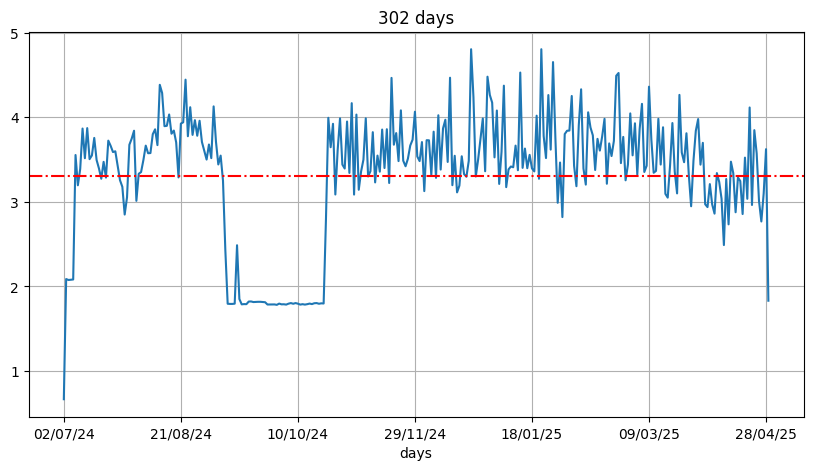

In [4520]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

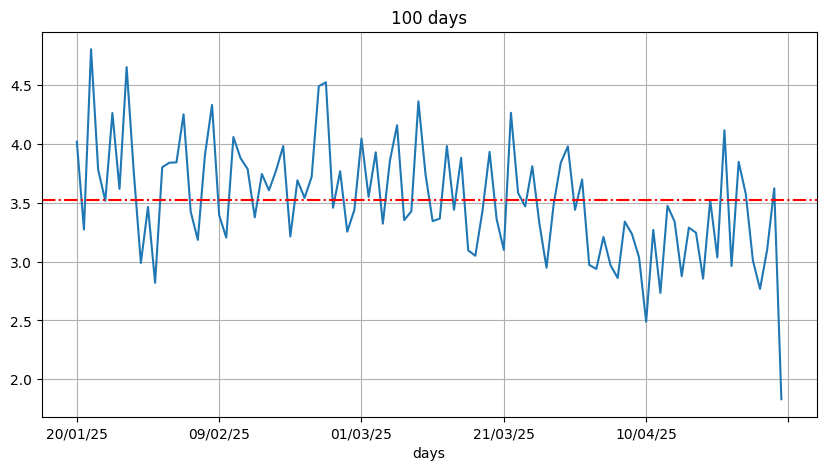

In [4521]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [4522]:
np.nanmean(df_grp.tail(span))

np.float64(3.52567)

In [4523]:
df_grp['kWh']

days
02/07/24    0.666
03/07/24    2.087
04/07/24    2.076
05/07/24    2.079
06/07/24    2.082
            ...  
25/04/25    3.010
26/04/25    2.768
27/04/25    3.100
28/04/25    3.623
29/04/25    1.831
Name: kWh, Length: 302, dtype: float64

In [4524]:
df_grp.describe()

,kWh
count,302.000000
mean,3.311258
std,0.755957
min,0.666000
25%,3.115750
50%,3.472500
75%,3.798000
max,4.805000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

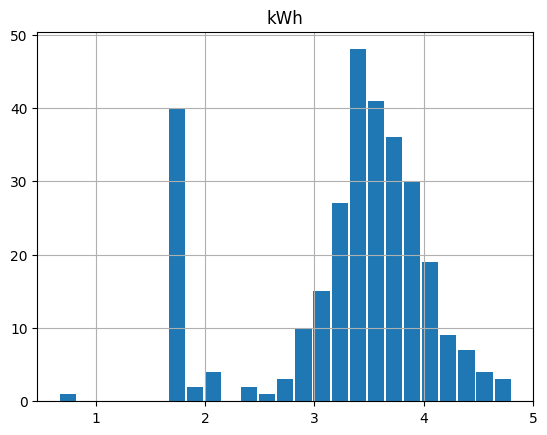

In [4525]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [4526]:
df_grp.tail(span)['kWh']

days
20/01/25    4.019
21/01/25    3.273
22/01/25    4.805
23/01/25    3.779
24/01/25    3.518
            ...  
25/04/25    3.010
26/04/25    2.768
27/04/25    3.100
28/04/25    3.623
29/04/25    1.831
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [4527]:
day

'29/04/25'

In [4528]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,107,107,NaN
01,100,207,-7.0
02,100,307,0.0
03,99,406,-1.0
04,99,505,0.0
05,98,603,-1.0
06,156,759,58.0
07,133,892,-23.0
08,129,1021,-4.0


In [4529]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


12

In [4530]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 13)

In [4531]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [4532]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [4533]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [4534]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [4535]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 00 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     12 non-null     int64  
 1   cumsum  12 non-null     int64  
 2   diff    11 non-null     float64
 3   days    12 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 480.0+ bytes


In [4536]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [4537]:
day

'29/04/25'

In [4538]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,107,107,NaN,1.0
01,100,207,-7.0,2.0
02,100,307,0.0,3.0
03,99,406,-1.0,4.0
04,99,505,0.0,5.0
05,98,603,-1.0,6.0
06,156,759,58.0,7.0
07,133,892,-23.0,8.0
08,129,1021,-4.0,9.0


In [4539]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_15908\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(1831)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '29/04/25: kWh    1831\ndtype: int64')

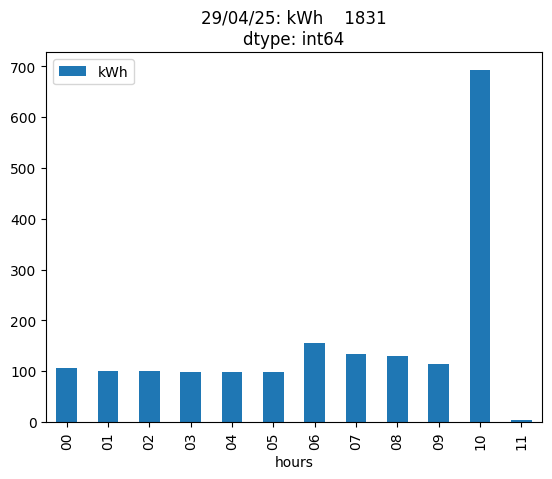

In [4540]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [4541]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'], dtype='object', name='hours')

# Conso du jour


In [4542]:

grp_by_dayhours.count()

kWh       7220
cumsum    7220
diff      6918
days        12
dtype: int64

'23/12/24'

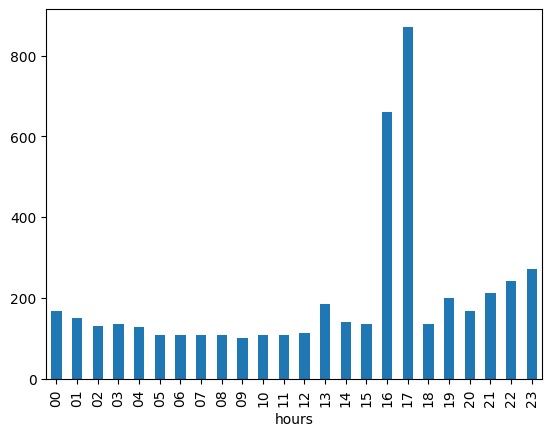

In [4543]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [4544]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [4545]:
df_grp.tail(7)['kWh']

days
23/04/25    3.848
24/04/25    3.575
25/04/25    3.010
26/04/25    2.768
27/04/25    3.100
28/04/25    3.623
29/04/25    1.831
Name: kWh, dtype: float64

Total= 352.567 , Moyenne= 3.52567


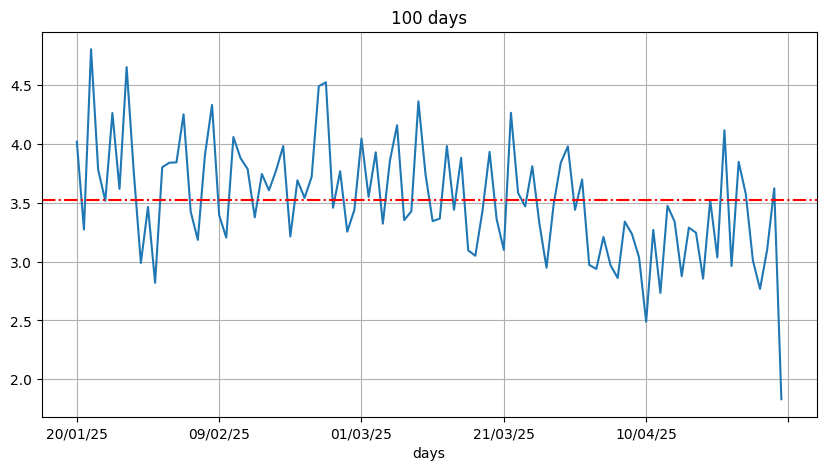

In [4546]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [4547]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 11:03:02, Minutes in day: 663


In [4548]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [4549]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

2:14.33


In [4550]:
end - start

134.32600235939026

# Today

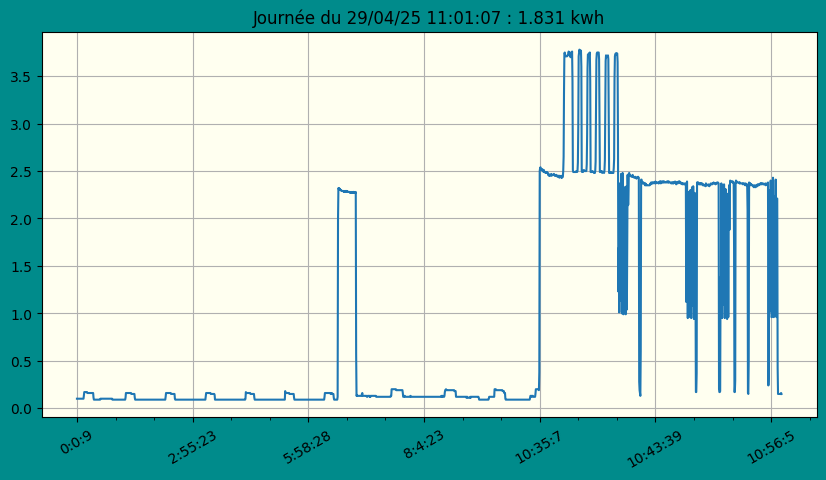

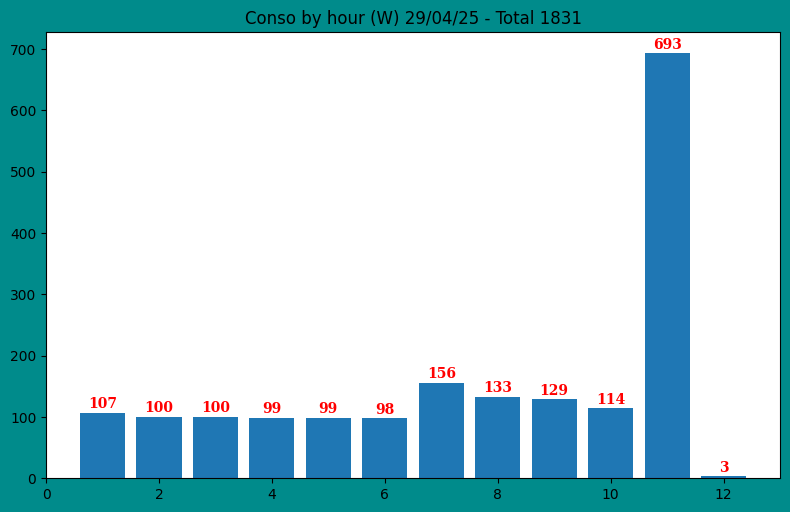

In [4551]:
show(today,bgcolor='ivory')
conso_by_hour(today)

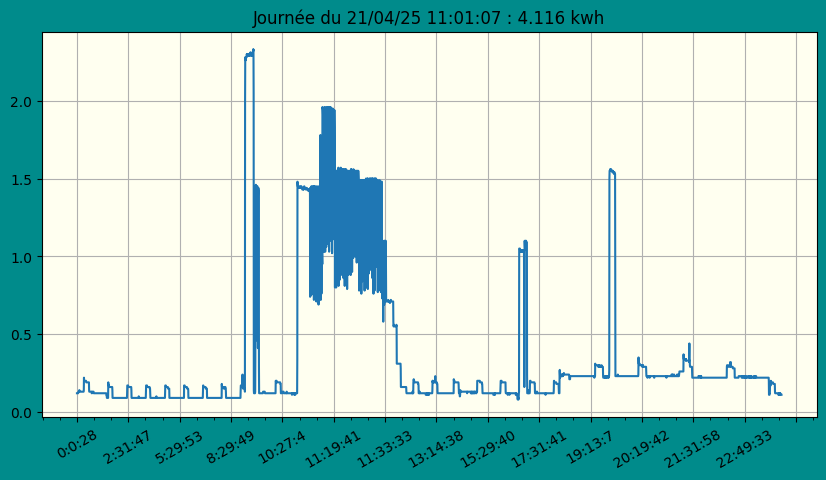

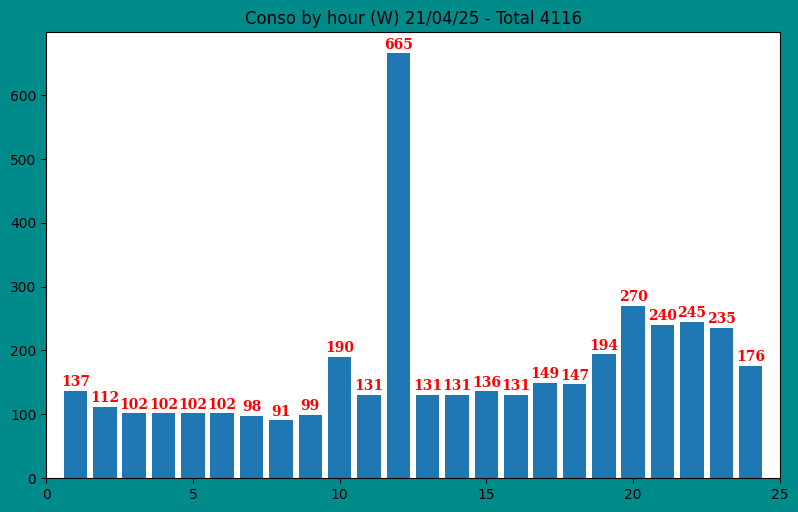

In [4552]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4805)

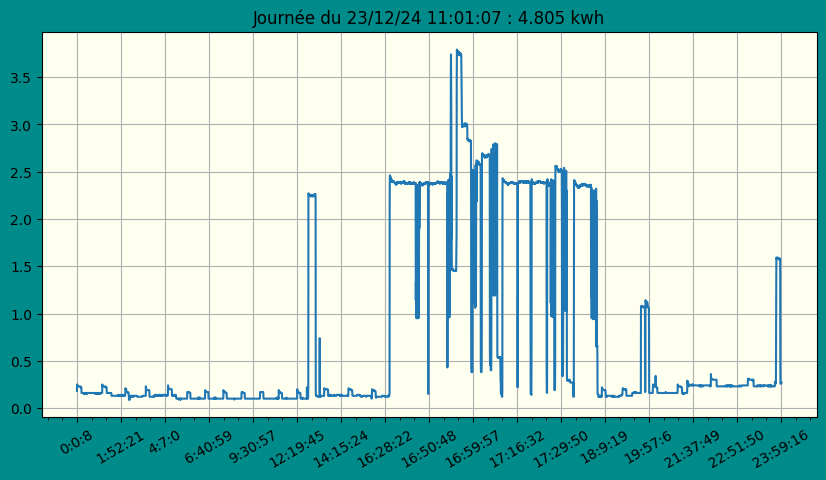

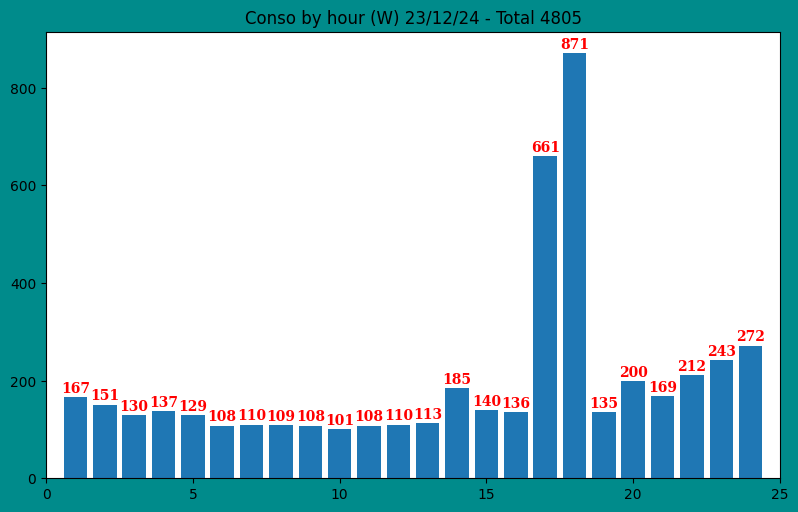

In [4553]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

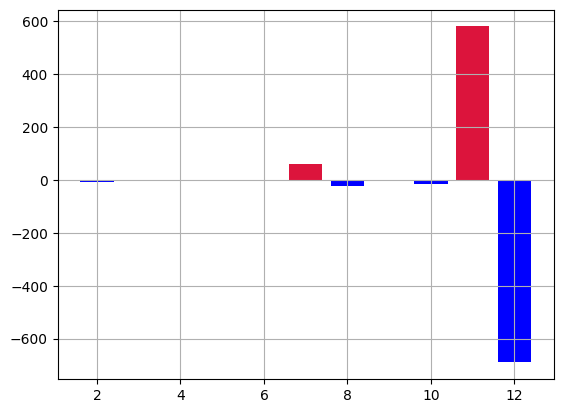

In [4554]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

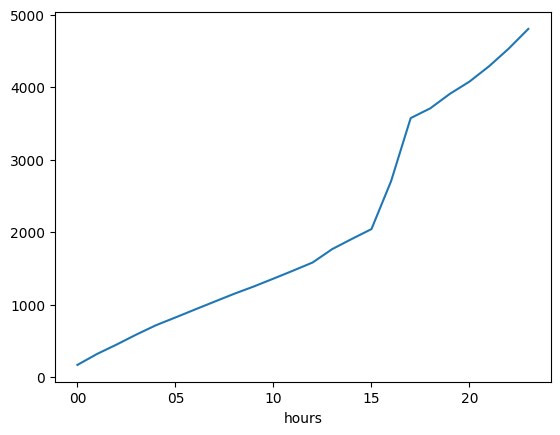

In [4555]:
data.cumsum().plot()


<Axes: xlabel='hours'>

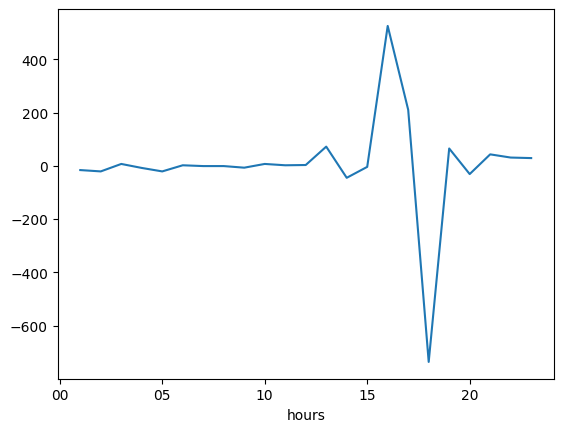

In [4556]:
# evolution par heure
data.diff().plot()

In [4557]:
data.diff().describe()

count     23.000000
mean       4.565217
std      199.814875
min     -736.000000
25%      -12.000000
50%        2.000000
75%       30.000000
max      525.000000
Name: kWh, dtype: float64

<Axes: >

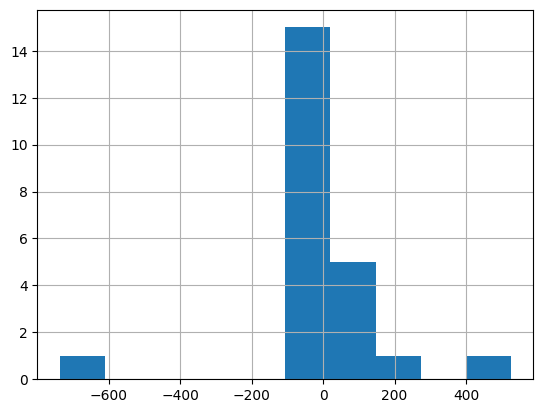

In [4558]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [4559]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [4560]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

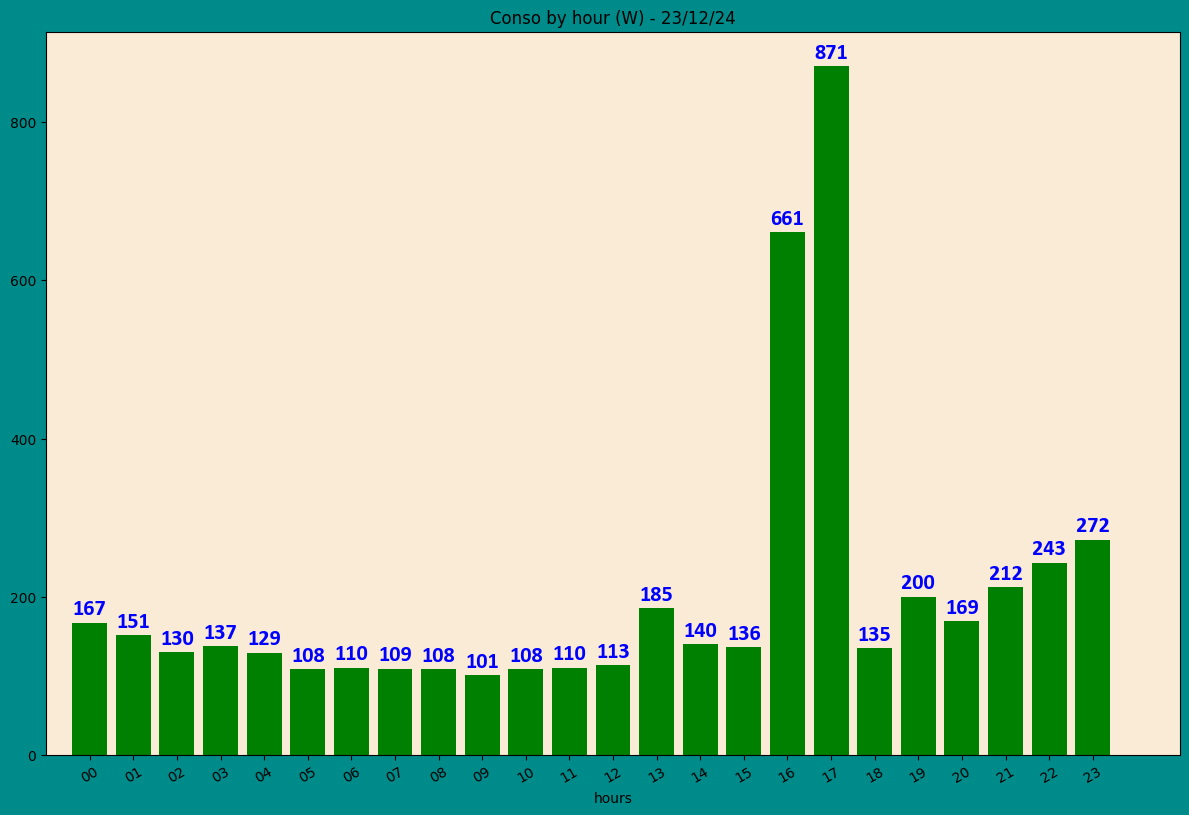

In [4561]:
day,conso_byhour(day)

In [4562]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


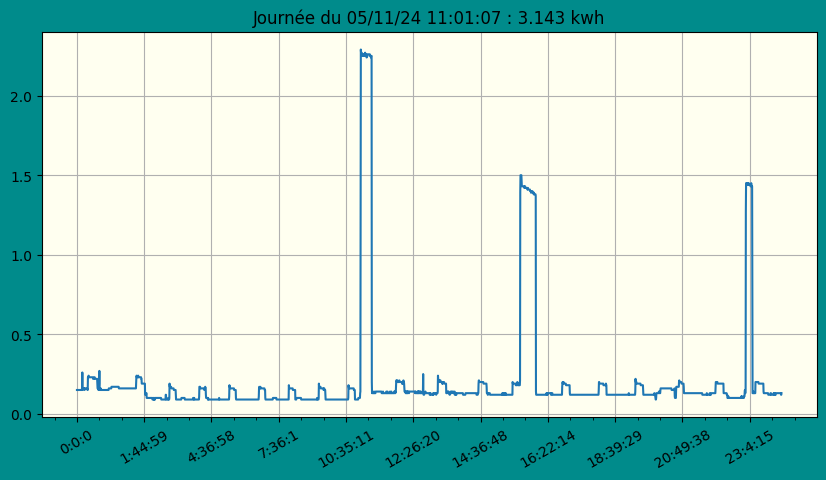

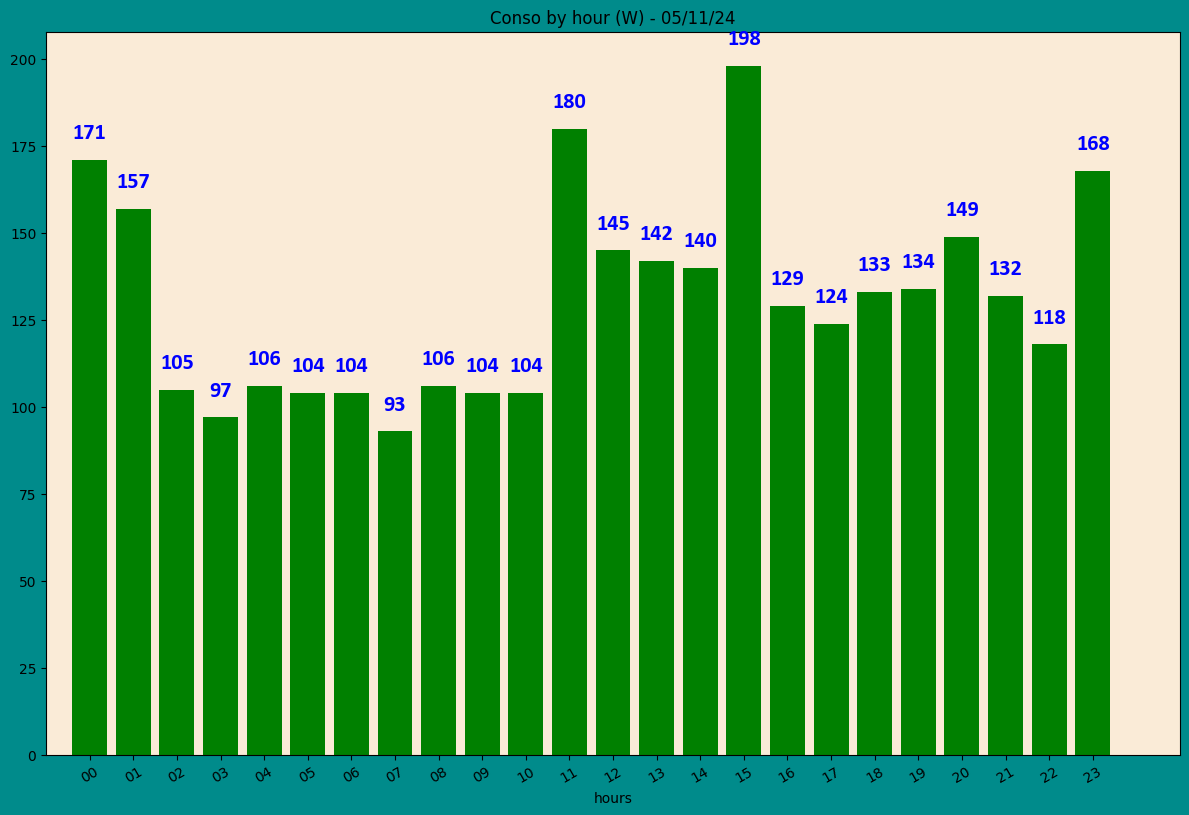

In [4563]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [4564]:
month

,day,hours,months,kWh
908771,01,00,2025-04,0.20
908772,01,00,2025-04,0.20
908773,01,00,2025-04,0.20
908774,01,00,2025-04,0.16
908775,01,00,2025-04,0.11
...,...,...,...,...
999995,29,10,2025-04,0.15
999996,29,10,2025-04,0.15
999997,29,11,2025-04,0.15
999998,29,11,2025-04,0.16


In [4565]:
month.describe()


,kWh
count,91229.000000
mean,0.313557
std,0.554412
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

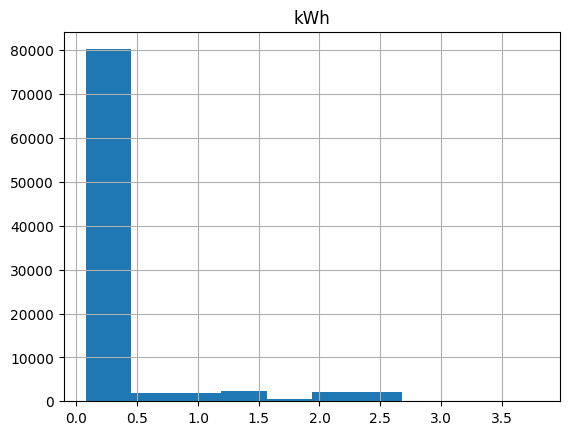

In [4566]:
month.hist()

<Axes: >

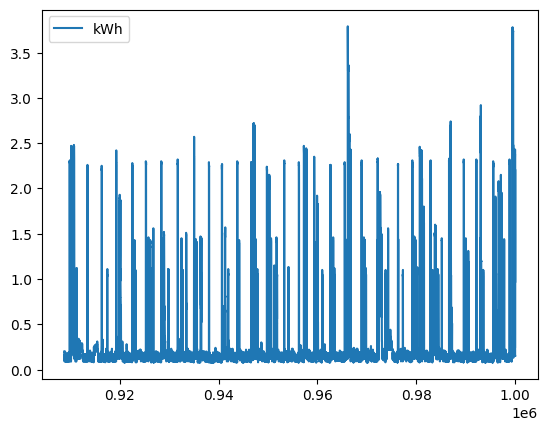

In [4567]:
month.plot()

In [4568]:
# index with max conso in this month
month.idxmax().kWh

np.int64(966127)

In [4569]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       998169
hours     912251
months    908771
kWh       966127
dtype: int64

In [4570]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [4571]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
02/07/24 16      63      63    NaN   NaN
         17      84     147   21.0   NaN
         18      92     239    8.0   NaN
         19      83     322   -9.0   NaN
         20      84     406    1.0   NaN
...             ...     ...    ...   ...
29/04/25 07     133     892  -23.0   8.0
         08     129    1021   -4.0   9.0
         09     114    1135  -15.0  10.0
         10     693    1828  579.0  11.0
         11       3    1831 -690.0  12.0

[7220 rows x 4 columns]

In [4572]:
month

,day,hours,months,kWh
908771,01,00,2025-04,0.20
908772,01,00,2025-04,0.20
908773,01,00,2025-04,0.20
908774,01,00,2025-04,0.16
908775,01,00,2025-04,0.11
...,...,...,...,...
999995,29,10,2025-04,0.15
999996,29,10,2025-04,0.15
999997,29,11,2025-04,0.15
999998,29,11,2025-04,0.16


In [4573]:
month.idxmax()


day       998169
hours     912251
months    908771
kWh       966127
dtype: int64

In [4574]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 966127, dtype: object

In [4575]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       157
          01       118
          02       101
          03       110
          04       111
          05       111
          06        98
          07       110
          08       110
          09       110
          10       167
          11       146
          12       148
          13       145
          14       188
          15       146
          16       198
          17       156
          18       151
          19       143
          20       155
          21       174
          22       222
          23       165
Name: kWh, dtype: int64

In [4576]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

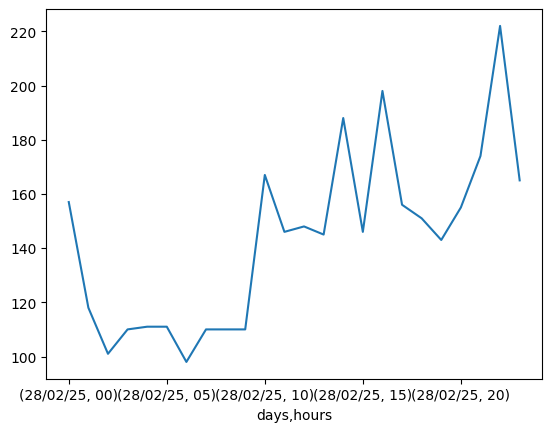

In [4577]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [4578]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [4579]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [4580]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [4581]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB